Stanley Raditya /262103671


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**File ini khusus untuk nomor 2D, agar tidak terlalu ruwet dalam satu file jadi saya buat di file yang berbeda untuk modelnya**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import glob

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model

from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D

from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

In [4]:
train_path = "/content/drive/MyDrive/Deep Learning/Dataset/train/*"
test_path = "/content/drive/MyDrive/Deep Learning/Dataset/test/*"
val_path = "/content/drive/MyDrive/Deep Learning/Dataset/validation/*"

Saya melakukan read data dengan IMREAD_COLOR agar bisa dibaca dengan menggunakan warna. Karena ada gambar yang backgroundnya daun dan pohon semua. Contohnya untuk cranberry yang berada di pohonnya, tanpa warna akan sangat sulit untuk membedakannya, tapi dengan megimplementasikan warna kita bisa tahu karena adanya perbedaan warna yang mencolok antara warna merah pada cranberry dan hijau pada daun2 di belakangnya

Tapi ada beberapa gambar juga yang mudah untuk dipelajari oleh si model karena backgroundnya hanya polos putih

Kita pakai RGB2BGR untuk konversi dari format RGB ke BGR karena VGG16 membutuhkan format input BGR.

In [105]:
train_data = []
train_labels = []

for directory_path in glob.glob(train_path):
    train_label = directory_path.split("\\")[-1]
    print(train_label)
    for img_path in glob.glob(os.path.join(directory_path, "*jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_data.append(img)
        train_labels.append(train_label)

/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (275).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (237).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (124).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (249).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (299).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (156).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (294).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (138).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (6).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (102).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (48).jpg
/content/drive/MyDrive/Deep Learning/Dataset/train/cempedak/cempedak (163)

In [6]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [7]:
test_data = []
test_labels = []

for directory_path in glob.glob(test_path):
    test_label = directory_path.split("\\")[-1]
    print(test_label)
    for img_path in glob.glob(os.path.join(directory_path, "*jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_data.append(img)
        test_labels.append(test_label)

/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (1).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (19).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (30).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (22).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (9).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (17).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (11).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (33).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (27).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (6).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (39).jpg
/content/drive/MyDrive/Deep Learning/Dataset/test/cranberry/cranberry (36)

In [8]:
test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [9]:
Encoded_train = LabelEncoder().fit_transform(train_labels)
Encoded_test = LabelEncoder().fit_transform(test_labels)

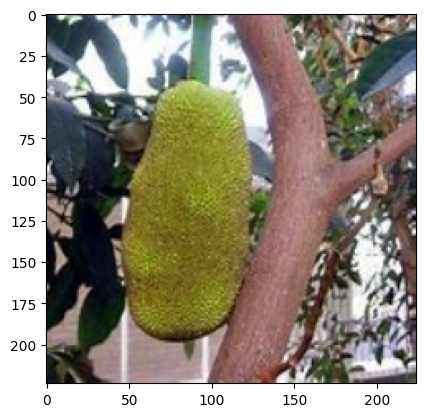

In [10]:
X_train, X_test, y_train, y_test = train_data, test_data, Encoded_train, Encoded_test
X_train, X_test = X_train/255, X_test/255
plt.imshow(X_train[12])

Dari dataset yang ada, saya menemukan beberapa yang menurut saya akan mengganggu proses training data. Contohnya ada beberapa yang gambarnya ada terdapat wajah orang, atau dalam satu kelas memiliki beberapa bentuk lagi. Semisal pada gambar cempedak, ada cempedak berwarna kuning dan hijau, ada yang utuh seperti duren dan ada yang sudah dibelah, dan bahkan ada yang hanya isinya saja diatas piring. Begitu pula dengan kacang mede, ada kacang mede yang masih di pohon dan masih ada buahnya dan ada kacang mede olahan.

In [18]:
from tensorflow.keras.layers import BatchNormalization


**VGG16**

VGG16 itu sebenarnya mirip dengan CNN akan tetapi kita melakukannya dengan layer yang lebih banyak dengan total 16 layers. Format input VGG defaultnya dan dimintanya adalah 244x244x3 dengan gambar BGR bukan RGB. 

VGG16 ini dibagi menjadi 2 tahap. Feature extraction dilakukan sebelum flatten, ini adalah tahapan dimana model kita mengambil atau mencari pola-pola, warna, pixel, garis, dsb dari gambar yang kita berikan sebagai training untuk dipelajari. Thap kedua adalah classification, dimana disini datanya akan memulai untuk memahami dan mengklasifikasikan data yang mereka baca/coba pelajari sebelumnya dengan 2 layer fully connected + relu activation dan softmax sebagai layer output diakhir karena kita menggunakannya untuk multiclass classification

Disini saya menggunakan batch normalization sebagai regulizer karena ya tujuan utamanya adalah melakukan normalisasi dari setiap output di layernya. Memang setiap iterasi dari training datanya akan menjadi lebih lambt karena ada kalkulasi ekstra ketika forward pass dan beberapa hyperparameter tambahan, tapi juga memaksimalkan training dari setiap layer dan membuatnya lebih stabil karena dilakukan normalisasi setiap output layer.

Kemudian kenapa optimizer saya menggunakan SGD? Karena optimizer Adam itu memiliki performa yang buruk untuk melakukan image classification. Adam itu proses belajarnya memang lebih cepat namun SGD walaupun lebih lama dia memliki optimisasi yang lebih baik dibandingkan oleh Adam

In [19]:
model = Sequential([
    Conv2D(64, kernel_size = (3,3), activation = "relu", input_shape = (224,224,3)),
    BatchNormalization(),
    Conv2D(64, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(128, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(128, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(256, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(256, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(256, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Conv2D(512, kernel_size = (3,3), activation = "relu"),
    BatchNormalization(),
    Flatten(),

    Dense(4096, activation = "relu"),
    BatchNormalization(),
    Dense(4096, activation = "relu"),
    BatchNormalization(),
    Dense(4, activation = "softmax")
])

model.compile(optimizer='sgd', loss="sparse_categorical_crossentropy", metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
model.fit(X_train, y_train, epochs = 100, batch_size=8, validation_data = (X_test, y_test))

Epoch 1/100
161/161 [==============================] - 36s 147ms/step - loss: 4.9423 - sparse_categorical_accuracy: 0.3416 - val_loss: 11.1002 - val_sparse_categorical_accuracy: 0.3478
Epoch 2/100
161/161 [==============================] - 23s 141ms/step - loss: 3.4949 - sparse_categorical_accuracy: 0.3874 - val_loss: 2.8964 - val_sparse_categorical_accuracy: 0.4348
Epoch 3/100
161/161 [==============================] - 22s 140ms/step - loss: 3.1703 - sparse_categorical_accuracy: 0.4123 - val_loss: 4.2727 - val_sparse_categorical_accuracy: 0.4596
Epoch 4/100
161/161 [==============================] - 23s 141ms/step - loss: 2.7816 - sparse_categorical_accuracy: 0.4325 - val_loss: 3.1875 - val_sparse_categorical_accuracy: 0.4099
Epoch 5/100
161/161 [==============================] - 23s 145ms/step - loss: 2.7988 - sparse_categorical_accuracy: 0.4379 - val_loss: 8.7116 - val_sparse_categorical_accuracy: 0.3043
Epoch 6/100
161/161 [==============================] - 24s 147ms/step - loss: 2

Accuracy yang diperoleh dari data ini hanyalah 0.68, dan lossnya berubah dari model pertama sekitar 4 menjadi 1,87. Ini terbukti kalau batch normalization bekerja dengan baik dan ckup mencegah overfitting

In [20]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 7s 96ms/step - loss: 1.8774 - sparse_categorical_accuracy: 0.6832


[1.8774079084396362, 0.6832298040390015]

Disini saya melakukan beberapa percobaan secara manual dengan memberikan gambar dari dataset X_test. Dari 10 percobaan yang saya lakukan sebelumnya saya mendapat kira-kira 8 tebakan benar dan 2 tebakan yang salah

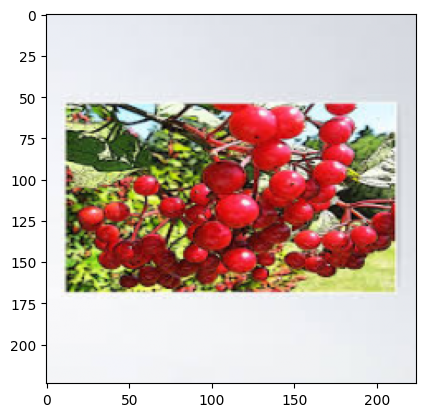

In [122]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [123]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 22ms/step
cranberry


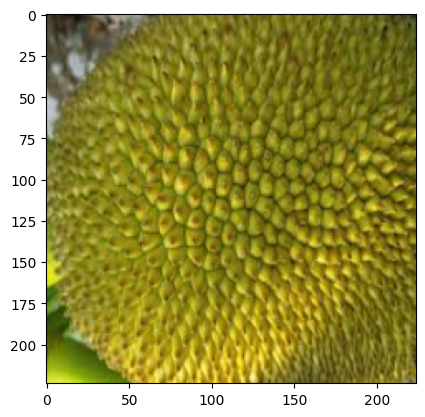

In [124]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [125]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 22ms/step
cempedak


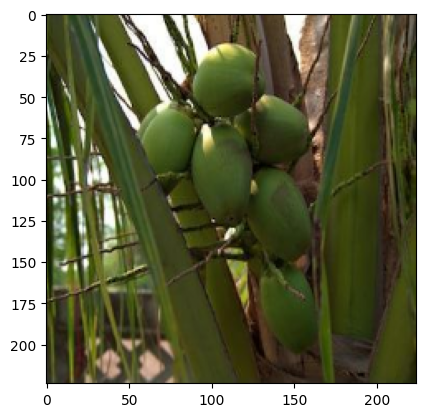

In [128]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [129]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 22ms/step
coconut


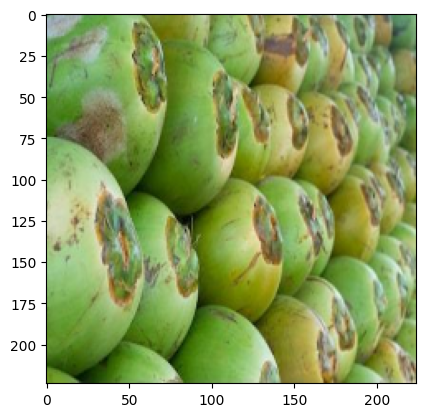

In [130]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [131]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 21ms/step
coconut


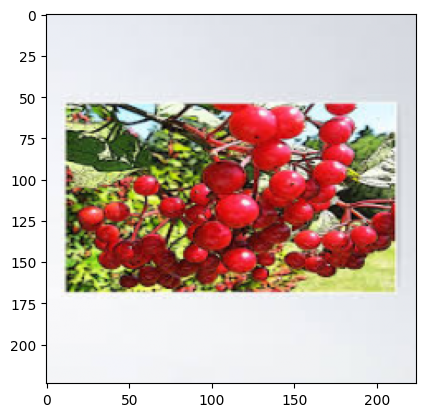

In [140]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [141]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 26ms/step
cranberry


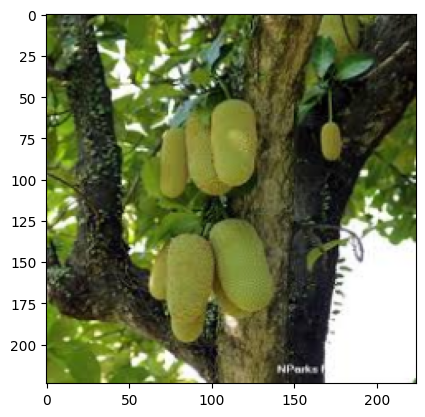

In [74]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [75]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 129ms/step
cempedak


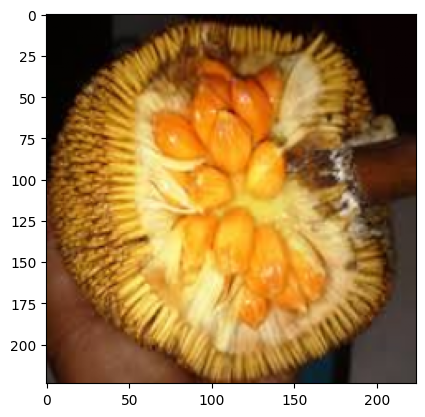

In [78]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [79]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 50ms/step
cempedak


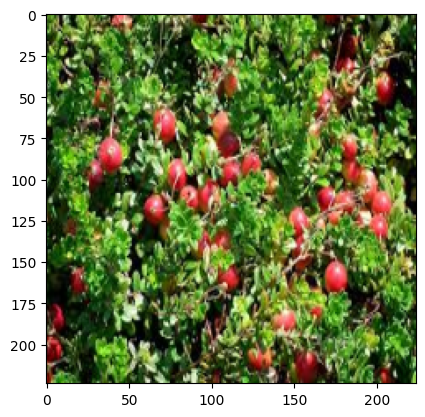

In [93]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [94]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 136ms/step
cranberry


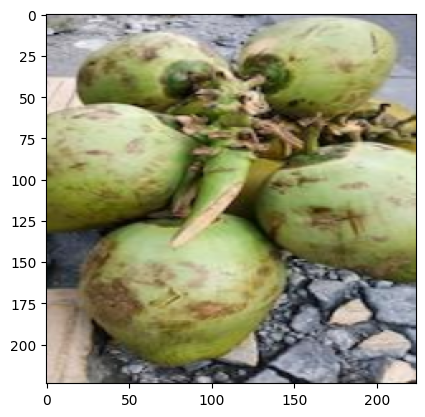

In [95]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [96]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 43ms/step
coconut


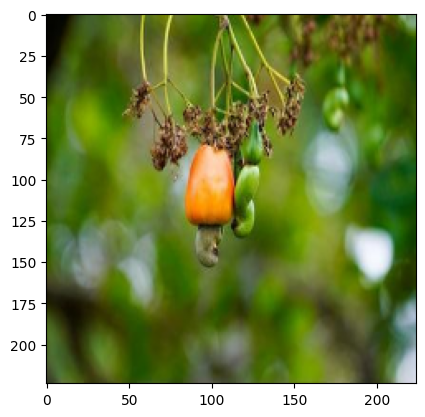

In [143]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()

In [146]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 25ms/step
cashew


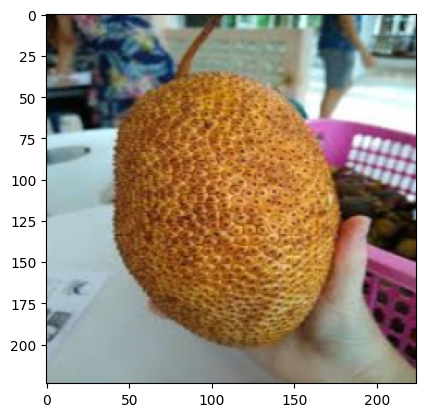

In [147]:
import random

i = random.randint(0, len(X_test))
plt.imshow(X_test[i])
plt.show()


In [148]:
y_pred = model.predict(X_test[i,:].reshape(1,224,224,3))
y_pred = np.argmax(y_pred)
y_pred
if(y_pred == 2):
  print("coconut")
elif(y_pred == 1):
  print("cempedak")
elif(y_pred == 0):
  print("cashew")
elif(y_pred == 3):
  print("cranberry")

1/1 [==============================] - 0s 38ms/step
cempedak
